In [45]:
# pre processamento de dados
import pandas as pd
import numpy as np

# deep learning framework
import torch
from torch import nn, optim
import torch.nn.functional as F

# scalers e métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Carregando o dataset

In [24]:
df = pd.read_csv('btc.csv', index_col='Date', parse_dates=True)
df.drop(columns=['Symbol'], inplace=True)
df.sort_values(by='Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume From,Volume To
Date,,,,,,
2014-12-01,300.0,370.0,300.00,370.0,0.05656,19.53
2014-12-02,370.0,378.0,370.00,378.0,15.01000,5675.07
2014-12-03,378.0,378.0,377.01,378.0,0.54660,206.52
2014-12-04,378.0,378.0,377.10,377.1,0.01000,3.77
2014-12-05,377.1,377.1,377.10,377.1,0.00000,0.00


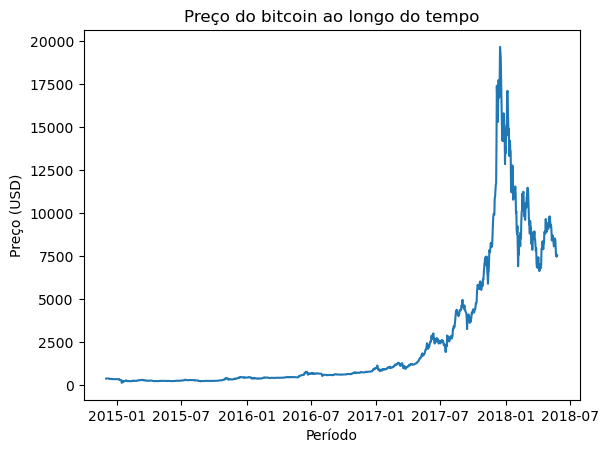

In [25]:
plt.plot(df.Close)
plt.xlabel("Período")
plt.ylabel("Preço (USD)")
plt.title("Preço do bitcoin ao longo do tempo")
plt.show();

In [26]:
# separando features e labels
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((1273, 5), (1273,))

In [28]:
mm = MinMaxScaler()
ss = StandardScaler()

X_scaled = ss.fit_transform(X)
y_scaled = mm.fit_transform(y.reshape(-1, 1))

In [30]:
# pega os n_steps_in input_sequences mais recentes para prever os próximos n_steps_out output_sequence
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_scaled, y_scaled, 100, 50)
print(X_ss.shape, y_mm.shape)

(1125, 100, 5) (1125, 50)


In [40]:
X_ss[0]

array([[-0.58087524, -0.56218474, -0.58526647, -1.03228266, -0.42210713],
       [-0.56238099, -0.56016332, -0.5655982 , -1.0307777 , -0.42205355],
       [-0.56026736, -0.56016332, -0.56362856, -1.03223334, -0.42210536],
       [-0.56026736, -0.56016332, -0.56360328, -1.03228734, -0.42210728],
       [-0.56050514, -0.56039073, -0.56360328, -1.03228835, -0.42210732],
       [-0.56050514, -0.56016332, -0.56360328, -1.03228684, -0.42210727],
       [-0.56026736, -0.56016332, -0.5633504 , -1.03228835, -0.42210732],
       [-0.56026736, -0.56016332, -0.56419333, -1.0322647 , -0.42210648],
       [-0.56105997, -0.56092136, -0.56419333, -1.03228835, -0.42210732],
       [-0.56105997, -0.55510977, -0.56826747, -1.03228634, -0.42210725],
       [-0.56489092, -0.56458518, -0.56826747, -1.03228835, -0.42210732],
       [-0.56489092, -0.55991065, -0.57121771, -1.03197133, -0.42209675],
       [-0.56766506, -0.5672383 , -0.57121771, -1.03228835, -0.42210732],
       [-0.56766506, -0.5672383 , -0.5

In [41]:
y_mm[0]

array([0.00883564, 0.00904403, 0.00901741, 0.00855095, 0.00841219,
       0.0085745 , 0.0088085 , 0.00854429, 0.00709217, 0.00733641,
       0.00735842, 0.00726216, 0.00768049, 0.00745571, 0.00659549,
       0.00650282, 0.00666462, 0.00658884, 0.0068341 , 0.0063277 ,
       0.00658423, 0.00641372, 0.00651562, 0.00688582, 0.00694726,
       0.00690579, 0.00724322, 0.00704403, 0.00694675, 0.0064849 ,
       0.00633129, 0.00593241, 0.00604864, 0.00604352, 0.00604352,
       0.00514747, 0.005319  , 0.00558577, 0.00529954, 0.00532463,
       0.0053277 , 0.00537839, 0.00588377, 0.00583717, 0.00591347,
       0.00575422, 0.00548182, 0.00514593, 0.00548899, 0.00540092])

In [35]:
y_scaled[99:149].squeeze(1)

array([0.00883564, 0.00904403, 0.00901741, 0.00855095, 0.00841219,
       0.0085745 , 0.0088085 , 0.00854429, 0.00709217, 0.00733641,
       0.00735842, 0.00726216, 0.00768049, 0.00745571, 0.00659549,
       0.00650282, 0.00666462, 0.00658884, 0.0068341 , 0.0063277 ,
       0.00658423, 0.00641372, 0.00651562, 0.00688582, 0.00694726,
       0.00690579, 0.00724322, 0.00704403, 0.00694675, 0.0064849 ,
       0.00633129, 0.00593241, 0.00604864, 0.00604352, 0.00604352,
       0.00514747, 0.005319  , 0.00558577, 0.00529954, 0.00532463,
       0.0053277 , 0.00537839, 0.00588377, 0.00583717, 0.00591347,
       0.00575422, 0.00548182, 0.00514593, 0.00548899, 0.00540092])

In [42]:
train_size = int(len(X_scaled)*0.80)
test_size = len(X_scaled) - train_size

train_size, test_size

(1018, 255)

In [43]:
X_train = X_ss[:-(test_size)]
X_test = X_ss[-(test_size):]

y_train = y_mm[:-(test_size)]
y_test = y_mm[-(test_size):]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (870, 100, 5) (870, 50)
Testing Shape: (255, 100, 5) (255, 50)


In [46]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [50]:
X_train_tensors.requires_grad = True
X_test_tensors.requires_grad = True

y_train_tensors.requires_grad = True
y_test_tensors.requires_grad = True